# Voronoi Tesellation for Superclustering
Creates a Voronoi tessellation on galaxy group data, calculates a measure of density using the Voronoi. Runs the data through a clustering algorithm in order to output a set of superclusters.


### The Data
The dataset used is the eRASS1 Galaxy groups and clusters primary catalogue. The main data that will be used from this dataset is the RA, DEC, BEST_Z, and M500 values.
- RA (deg): the right ascension. Describes the angular distance of an object as measured from the vernal equinox eastward, acting as a longitude value.
- DEC (deg): the declination. Describes the distance as measured from the equator, acting as a latitude value.
- BEST_Z : describes the approximate redshift value of the object. This is used to determine the distance of the object.
- M500 ($10^{13} M_\odot$): Mass of the galaxy cluster within the virial radius

Values to determine the veracity and value of the data during preprocessing include:
- BEST_ZERR : the 1 sigma error of the redshift value. Low confidence redshift values are undesirable.
- PCONT : Probability of being a contaminant. Contaminants are not ideal for the dataset.
- CR500_0520 : The X-ray photon count within R500, within 0.5-2.0keV


The dataset is downloaded from the [eRASS1 website](https://erosita.mpe.mpg.de/dr1/).

The datasets can be accessed through the [source catalogue](https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/). The datasets used:
- eROSITA/eRASS1 galaxy groups and clusters main catalogue
- eROSITA/eRASS1 supercluster catalogue



In [ ]:
# read in galaxy cluster data
from astropy.table import Table
import pandas as pd

gcfit = Table.read('/content/erass1cl_primary_v3.2.fits', format='fits')
# throw out unnecessary data, convert to pandas
gcfit.keep_columns(["RA", "DEC", "BEST_Z", "M500", "BEST_ZERR", "PCONT", "CR500_0520"])
gcdf = gcfit.to_pandas()
gcdf.describe()

,RA,DEC,BEST_Z,BEST_ZERR,PCONT,CR500_0520,M500
count,12247.000000,12247.000000,12247.000000,12247.000000,12247.000000,12247.000000,12247.000000
mean,126.323755,-32.057764,0.361723,-0.003477,0.136064,0.585483,20.130506
std,85.246251,29.701852,0.246290,0.113280,0.254466,8.653764,20.801520
min,0.021730,-89.385855,0.003000,-1.000000,0.000000,0.000000,-1.000000
25%,60.118408,-55.831168,0.170100,0.002400,0.002000,0.067000,6.895000
50%,98.832253,-34.275920,0.307400,0.007400,0.016000,0.139000,16.660000
75%,185.203628,-11.083056,0.505400,0.011700,0.104500,0.324000,27.935000
max,359.983837,41.236798,1.321900,0.146700,1.000000,890.348000,1000.000000


In [ ]:
# preprocessing
# remove clusters that do not have a recorded mass
gcdf = gcdf.drop(gcdf[gcdf.M500 < 0].index)
# remove clusters with a low Cr500_0520
gcdf = gcdf.drop(gcdf[gcdf.CR500_0520 < .005].index)
# remove clusters with a high contaminant
gcdf = gcdf.drop(gcdf[gcdf.PCONT > 0.3].index)
# remove clusters with unreliable redshifts
gcdf = gcdf.drop(gcdf[gcdf.BEST_ZERR < 0].index)
# remove clusters that are too nearby
gcdf = gcdf.drop(gcdf[gcdf.BEST_Z < .005].index)
gcdf.describe()

,RA,DEC,BEST_Z,BEST_ZERR,PCONT,CR500_0520,M500
count,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000
mean,126.186451,-32.281613,0.336615,0.007495,0.035636,0.498641,24.776515
std,84.970991,29.803174,0.224165,0.008530,0.057960,1.707049,18.100380
min,0.021730,-89.385855,0.007800,0.000000,0.000000,0.010000,0.510000
25%,60.386398,-56.363448,0.167950,0.001500,0.001000,0.102000,12.487500
50%,98.476867,-34.719000,0.290250,0.006500,0.009000,0.203000,20.490000
75%,183.772018,-10.959751,0.450625,0.009600,0.044000,0.427250,31.842500
max,359.983837,41.236798,1.321900,0.146700,0.299000,74.097000,161.770000


## Calculating Distance

The distance is calculated using the comoving distance:
$$a = \frac{1}{(1+z)}$$
$$X(a) = \Omega_m/a + \Omega_r/a^2 + \Omega_va^2 + (1 - \Omega_{tot})$$
$$D_M = \int_{\frac{1}{(1 + z)}}^{1} \frac{da}{a\sqrt{X}}$$

These equations are rearranged from those in the report.

Further conversion to luminosity distance for testing:
$$J(x) = 1 + \frac{x}{6} + ... + \frac{x^n}{(2n+1)!}+...$$
$$ D_L = J((1-\Omega_{tot})Z^2)(1+z)D_M$$

In [ ]:
# find distance from redshift
import numpy as np
from astropy import constants as const
from astropy.cosmology import WMAP9
import astropy.units as u
import astropy.cosmology.units as cu

# calculate luminosity distance
def lumi_dist(z, test=False):
  H0 = 69.33
  wVac = .712  # vacuum, assume flat universe
  wM = 1 - wVac  # density ratio
  wro = (4.165e-5) / np.square(H0/100)
  wK = 1 - wM - wVac - wro  # assume flat universe
  ainv = 1. / (1. + z)  # cut down on division

  # comoving radial distance (c/H0)
  step = ((1 - ainv) / 1000)
  ato1 = np.arange(ainv, 1 + step, step)
  Xa = 1 / (np.sqrt((wM / ato1) + (wro / np.square(ato1)) \
               + (wVac * np.square(ato1)) + wK) * ato1)
  Z = np.trapz(Xa , ato1)
  #print(Z)

  # to comoving distance (transverse)
  # junction function is when x=0, ==> 1 + x/6 + x^2/120 (approx.)
  x = wK * np.square(Z)
  #DCMT = (1 + (x / 6) + ((x**2) / 120)) * Z
  DCMT = Z
  if test:
    return DCMT * ((1 + z))

  return DCMT

# convert to mpc  (x * (c / H0))
def to_mpc(dl):
  H0 = 69.33
  return dl * (const.c.to('km/s') / H0)

# sample run
print("{0:.2f} Mpc".format(to_mpc(lumi_dist(3, True)))) # Mpc


25973.08 km / s Mpc


In [ ]:
vect_lumi = np.vectorize(lumi_dist)
gcdf["DM"] = vect_lumi(gcdf.BEST_Z.values)

### Figure 3
A comparison between redshift and comoving distance.

Text(0.5, 0, 'DM')

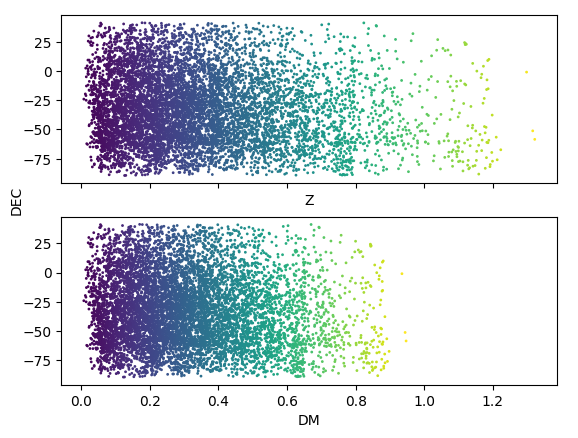

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import math

fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_ylabel("DEC")


subplot1 = fig.add_subplot(211)
plt.scatter(x=gcdf["BEST_Z"], y=gcdf["DEC"], s=1, c=gcdf["BEST_Z"], cmap="viridis")
plt.tick_params('x', labelbottom=False)
plt.xlabel("Z")
#subplot1.set_facecolor((0.3, 0.3, 0.3, 0.2))

subplot2 = fig.add_subplot(212, sharex=subplot1, sharey=subplot1)
#subplot2.set_facecolor((0.1, 0.1, 0.3, 0.2))
plt.scatter(x=gcdf["DM"], y=gcdf["DEC"], s=1, c=gcdf["DM"], cmap="viridis")
plt.xlabel("DM")

### Figure 4
The galaxy cluster data as using the equatorial coordinates

<ipython-input-6-3d8e76337edf>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subp = plt.subplot(projection = 'aitoff')


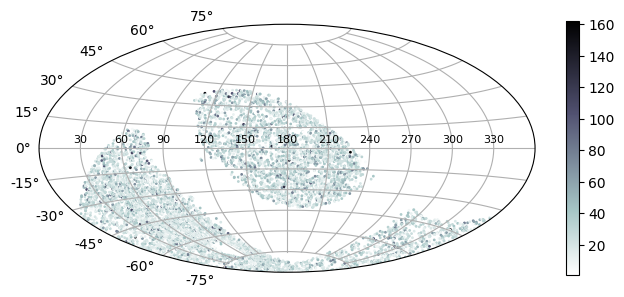

In [ ]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(8,6))
plt.title("Mass (M500)")
subp = plt.subplot(projection = 'aitoff')
subp.grid(True)
subp.set_xticklabels(np.arange(30,360,30), fontsize=8)
plt.scatter(((gcdf.RA - 180) * (math.pi / 180)), (gcdf.DEC * (math.pi / 180)), s=1, c=gcdf.M500, cmap="bone_r")
plt.colorbar(shrink=.55)

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord

# scale the distance a bit so that we dont have to deal with even smaller values
# this has no effect on the outcome, just the e value of the distance threshold
carts = SkyCoord(ra=np.array(gcdf.RA) * u.degree, dec=np.array(gcdf.DEC) * u.degree,
                 distance=np.array(gcdf.DM * 10)).galactic.cartesian

gcdf["x"] = carts.x
gcdf["y"] = carts.y
gcdf["z"] = carts.z

### 3D Representation of Figure 4

In [ ]:
import plotly.express as px

fig = px.scatter_3d(x=gcdf.x, y=gcdf.y, z=gcdf.z, color=gcdf.DM, size=gcdf.M500)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),
                  scene_camera=dict(eye=dict(x=1.5, y=1.5, z=.1),
                                    center=dict(x=0,y=0,z=-.1)),
                  coloraxis_colorbar_title_text="Distance")
fig.update_traces(marker=dict(line=dict(width=0)))

In [ ]:
gcdf.describe()

,RA,DEC,BEST_Z,BEST_ZERR,PCONT,CR500_0520,M500,DM,x,y,z
count,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000
mean,126.186451,-32.281613,0.336615,0.007495,0.035636,0.498641,24.776515,0.299672,-0.018498,-1.581203,-0.662862
std,84.970991,29.803174,0.224165,0.008530,0.057960,1.707049,18.100380,0.178229,1.436777,1.396289,2.281163
min,0.021730,-89.385855,0.007800,0.000000,0.000000,0.010000,0.510000,0.007787,-6.110111,-8.598990,-8.398173
25%,60.386398,-56.363448,0.167950,0.001500,0.001000,0.102000,12.487500,0.161671,-0.776610,-2.244076,-2.206406
50%,98.476867,-34.719000,0.290250,0.006500,0.009000,0.203000,20.490000,0.271366,-0.026325,-1.172492,-0.974105
75%,183.772018,-10.959751,0.450625,0.009600,0.044000,0.427250,31.842500,0.404540,0.709087,-0.510771,0.971240
max,359.983837,41.236798,1.321900,0.146700,0.299000,74.097000,161.770000,0.947012,6.681478,0.001824,8.408967


## The Voronoi
The density value of a space is an important value in determining superclusters. Most algorithms currently used are based on a density threshold to group together data. In this project, a 3D voronoi diagram is created using the positional data, after which the volume of each cell will be approximated. This volume can then be used to find the density of the region for clustering.

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.preprocessing import normalize
import numpy as np

points = np.column_stack((gcdf.x, gcdf.y, gcdf.z))

vor = Voronoi(points)

### Figure 2

Two voronoi plots are viewed below, using the converted (x,y,z) from the RA and DEC values. The first plot is taken on the yz plane, the second is on the xz-plane. The bounding hyperplane can be seen in the yz-plane where all points are below (to the left of) y=0. In the xz-plane the general outline of the data can be seen. This can be put into a singular bounding sphere in order to mitigate the effects of an unbounded cell on density calculation for a point.

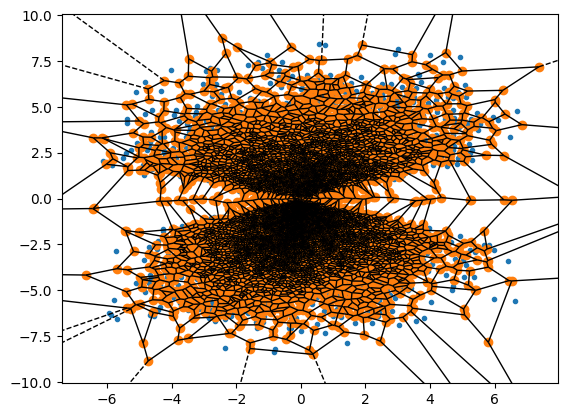

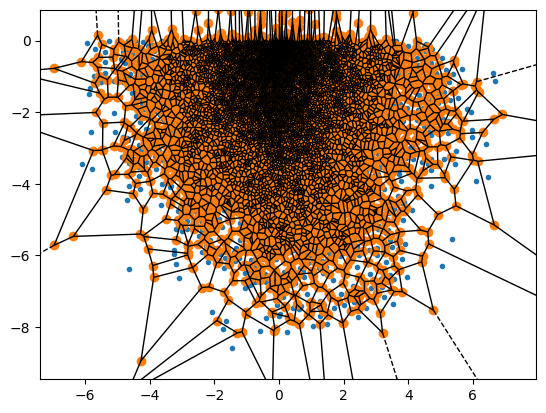

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

v2d = Voronoi(np.column_stack((gcdf.x, gcdf.z)))
o = voronoi_plot_2d(v2d)
v2d = Voronoi(np.column_stack((gcdf.x, gcdf.y)))
o = voronoi_plot_2d(v2d)

## The Model



###Finding the Volume
Each cell of the Voronoi will be a convex volume. By finding a Delaunay triangulation of each cell, the sum of the volumes of each tetrahedron within the Delaunay gives the volume of the cell as a whole.

In [ ]:
import numpy as np
from scipy.spatial import Delaunay

# check if point lies in bounding sphere at origin
def bounding_sphere(point, br):
  if (point[0]**2 + point[1]**2 + point[2]**2) > br**2:
    return False
  return True

# tetrahedron volume
def tetra_vol(t):
  l1 = t[0] - t[3]
  l2 = t[1] - t[3]
  l3 = t[2] - t[3]
  v = np.abs(np.dot(l1, np.cross(l2, l3)))
  return v / 6


# calculate volume of a voronoi cell
def d_volume(vertices):
  d_shape = Delaunay(vertices)
  tetras = vertices[d_shape.simplices]
  vol = 0
  for tetra in tetras:
    vol += tetra_vol(tetra)
  return vol

# define a cube
cube = np.array([[0,0,0], [0,1,0], [1,1,0], [1,0,0],
        [0,0,1], [0,1,1], [1,1,1], [1,0,1]])
d_volume(cube)

0.9999999999999999

In [ ]:
pos = np.array(vor.points)
vols = np.empty(pos.shape[0])

# find bounding radius
bound_radius = 0
for i in range(len(pos)):
  if bounding_sphere(pos[i], bound_radius) is False:
    bound_radius = np.sqrt((pos[i][0]**2 + pos[i][1]**2 + pos[i][2]**2))

# add an epsilon
_epsilon = 1e-1
bound_radius += _epsilon
hplane = _epsilon
print("bounding radius: ", bound_radius)

for i in range(len(vor.point_region)):
  verts = vor.vertices[vor.regions[vor.point_region[i]]]
  for j in range(len(verts)):
    if verts[j][1] > hplane:
      verts[j][1] = hplane
    elif bounding_sphere(verts[j], bound_radius) is False:
      verts[j] = (bound_radius / np.linalg.norm(verts[j])) * verts[j]
      # print("vert out of bounds, readjusting to: ", vert, " in ", np.linalg.norm(vert))
    #else:
      #print("vert in bounds :)")
  vols[i] = d_volume(verts)

voldf = pd.DataFrame(pos, columns=['x', 'y', 'z'])
voldf["vol"] = vols

bounding radius:  9.570123505322636


In [ ]:
data = gcdf.merge(voldf, on=["x", "y", "z"])
data["density"] = data.M500 / data.vol
data["ivol"] = 1 / data.vol
data.describe()

,RA,DEC,BEST_Z,BEST_ZERR,PCONT,CR500_0520,M500,DM,x,y,z,vol,density,ivol
count,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8.776000e+03,8776.000000
mean,126.186451,-32.281613,0.336615,0.007495,0.035636,0.498641,24.776515,0.299672,-0.018498,-1.581203,-0.662862,1.196188,1.455687e+04,978.556900
std,84.970991,29.803174,0.224165,0.008530,0.057960,1.707049,18.100380,0.178229,1.436777,1.396289,2.281163,33.118389,3.217236e+05,10972.369623
min,0.021730,-89.385855,0.007800,0.000000,0.000000,0.010000,0.510000,0.007787,-6.110111,-8.598990,-8.398173,0.000002,1.038211e-02,0.000379
25%,60.386398,-56.363448,0.167950,0.001500,0.001000,0.102000,12.487500,0.161671,-0.776610,-2.244076,-2.206406,0.003977,4.219450e+02,18.261678
50%,98.476867,-34.719000,0.290250,0.006500,0.009000,0.203000,20.490000,0.271366,-0.026325,-1.172492,-0.974105,0.013935,1.375903e+03,71.760462
75%,183.772018,-10.959751,0.450625,0.009600,0.044000,0.427250,31.842500,0.404540,0.709087,-0.510771,0.971240,0.054759,3.959771e+03,251.440962
max,359.983837,41.236798,1.321900,0.146700,0.299000,74.097000,161.770000,0.947012,6.681478,0.001824,8.408967,2639.156284,2.659628e+07,527560.027437


### Figure 5
The calculated densities of the galaxy cluster data.

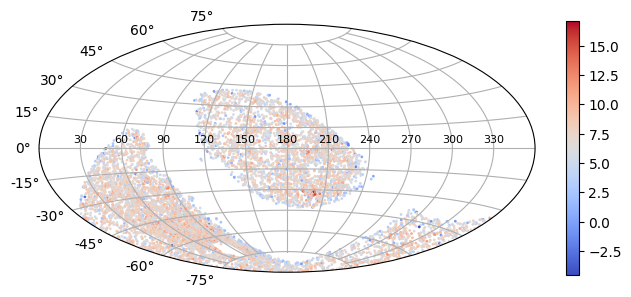

In [ ]:
from sklearn.preprocessing import normalize
import math

# xyz log density
sd = normalize(np.array(data.density).reshape(-1,1))
plt.figure(figsize=(8,6))
subp = plt.subplot(projection = 'aitoff')
subp.set_xticklabels(np.arange(30,360,30), fontsize=8)
plt.grid(True)
plt.scatter(((data.RA - 180) * (math.pi / 180)), (data.DEC * (math.pi / 180)), s=1, c=np.log(data.density), cmap="coolwarm")
plt.colorbar(shrink=.55)

### 3D Representation of Figure 5

In [ ]:
import plotly.express as px

# xyz, log density
fig = px.scatter_3d(x=data.x, y=data.y, z=data.z, color=np.log(data.density),
                    size=np.log(data.density)**2)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),
                  scene_camera=dict(eye=dict(x=1.5, y=1.5, z=.1),
                                    center=dict(x=0,y=0,z=-.1)),
                  coloraxis_colorbar_title_text="density")
fig.update_traces(marker=dict(line=dict(width=0)))

In [ ]:
# the distance function
from sklearn.metrics import pairwise_distances

def density_distance(p1, p2):
  diff = np.subtract(p2[0:3], p1[0:3])
  dist = np.divide(np.dot(diff, diff), np.sqrt(p1[3] * p2[3]))
  #print(dist)
  return dist

def dense_affinity(X):
  return pairwise_distances(X, metric=density_distance)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# generate the model
m_data = np.column_stack((data.x, data.y, data.z, data.density))
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=5e-6, metric=dense_affinity, linkage="average")
labels = ac.fit_predict(m_data)
print("Clusters found: ", len(set(ac.labels_)))

Clusters found:  5965


## Model Analysis


In [ ]:
# read in supercluster data
from astropy.table import Table
import pandas as pd

scfit = Table.read('/content/erass1sc.fits', format='fits')
# throw out unnecessary data, convert to pandas
scfit.keep_columns(["ra", "dec", "redshift", "multiplicity", "reliability"])
scdf = scfit.to_pandas()


In [ ]:
from astropy.coordinates import SkyCoord

# find centroids of each cluster in output
centroids = {}
for i in range(len(data)):
  center = 0
  label = labels[i]
  d = data.iloc[i]
  if label in centroids.keys():
    centroids[label]['memc'] += 1
    centroids[label]['x'] += float(d.x)
    centroids[label]['y'] += float(d.y)
    centroids[label]['z'] += float(d.z)
  else:
    centroids[label] = {'memc' : 1,
                        'x': float(d.x),
                        'y': float(d.y),
                        'z': float(d.z)}

for i in centroids:
  centroids[i]['x'] = centroids[i]['x'] / centroids[i]['memc']
  centroids[i]['y'] = centroids[i]['y'] / centroids[i]['memc']
  centroids[i]['z'] = centroids[i]['z'] / centroids[i]['memc']

# convert xyz back to spherical
cdf = pd.DataFrame(centroids).transpose()
coords = SkyCoord(x=cdf['x'], y=cdf['y'], z=cdf['z'], representation_type='cartesian')
cdf["RA"] = coords.spherical.lon.deg
cdf["DEC"] = coords.spherical.lat.deg # still in galactic

gcscoord = SkyCoord(l=cdf["RA"], b=cdf["DEC"], unit='deg', frame="galactic")
cdf["RA"] = gcscoord.icrs.ra.deg
cdf["DEC"] = gcscoord.icrs.dec.deg

Total clusters found by the model:

In [ ]:
# total clusters found with size above 1
print("Clusters found: ",len(cdf[cdf["memc"] > 1]))

Clusters found:  1053


In [ ]:
cdf[cdf["memc"] > 1].describe()

,memc,x,y,z,RA,DEC
count,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000
mean,3.669516,-0.047620,-1.194614,-0.637179,121.412544,-32.626640
std,5.086793,0.913406,0.939180,1.593035,84.902955,29.426589
min,2.000000,-3.630171,-5.466032,-4.157760,0.220163,-89.554897
25%,2.000000,-0.617460,-1.709497,-1.738788,56.345041,-56.156409
50%,2.000000,-0.031629,-0.983328,-0.944408,93.176201,-36.030259
75%,4.000000,0.534919,-0.468834,0.737594,180.177149,-11.908267
max,82.000000,3.078158,-0.003812,4.016285,359.324741,39.820817


In [ ]:
scdf.describe()

,redshift,ra,dec,multiplicity,reliability
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.260424,123.007152,-33.128905,2.950673,0.757818
std,0.149354,86.931336,29.219428,2.226976,0.177598
min,0.009900,0.147100,-88.367600,2.000000,0.210000
25%,0.145925,57.081625,-56.123225,2.000000,0.630000
50%,0.233450,90.934850,-37.294050,2.000000,0.770000
75%,0.347550,182.025675,-12.889225,3.000000,0.910000
max,0.801900,359.688400,39.855400,45.000000,1.000000


Total number of cluster members in clusters with size > 1.

In [ ]:
cdf[cdf["memc"] > 1].memc.sum()

3864.0

In [ ]:
scdf.multiplicity.sum()

3948

### Figure 6
Comparison of cluster size distribution between the valid and Voronoi models

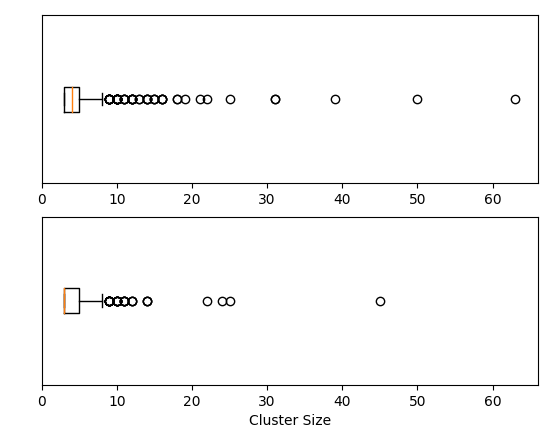

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel("Cluster Size")

bp1 = fig.add_subplot(211)
bp1.boxplot(cdf[np.logical_and(cdf["memc"] > 2, cdf["memc"] < 70)].memc.values, vert=False)
bp1.set(yticklabels=[])
bp1.tick_params(left=False)
bp2 = fig.add_subplot(212, sharex=bp1)
bp2.boxplot(scdf[scdf['multiplicity'] > 2].multiplicity.values, vert=False)
bp2.set(yticklabels=[])
bp2.tick_params(left=False)

plt.show()

### Comparing counts of clusters of particular sizes

In [ ]:
cdf[cdf["memc"] == 6].count()

memc    27
x       27
y       27
z       27
RA      27
DEC     27
dtype: int64

In [ ]:
scdf[scdf["multiplicity"] ==6 ].count()

redshift        28
ra              28
dec             28
multiplicity    28
reliability     28
dtype: int64

### Figure 7a

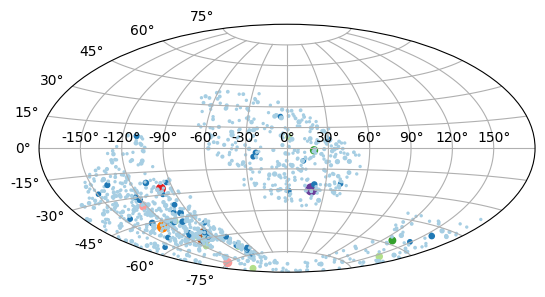

In [ ]:
# VORONOI MODEL
no1cdf = cdf[cdf["memc"] > 1]
plt.figure()
plt.subplot(projection = 'aitoff')
plt.grid(True)
plt.scatter(((no1cdf.RA - 180) * (math.pi / 180)), (no1cdf.DEC * (math.pi / 180)), s=no1cdf['memc'] , c=no1cdf['memc'], cmap="Paired")

### Figure 7b

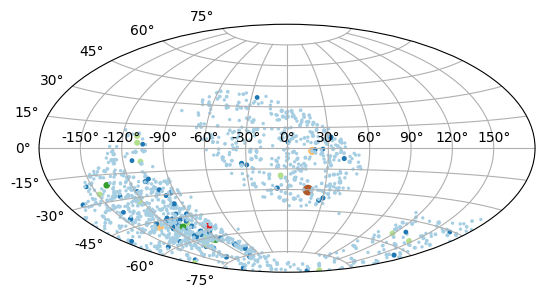

In [ ]:
# VALID MODEL
plt.figure()
plt.subplot(projection = 'aitoff')
plt.grid(True)
plt.scatter(((scdf.ra - 180) * (math.pi / 180)), (scdf.dec * (math.pi / 180)), s=scdf.multiplicity, c=scdf.multiplicity, cmap="Paired")

#### Comparing major clusters

In [ ]:
scdf.sort_values('multiplicity', ascending=False)[['ra', "dec", "multiplicity"]].head(5)

,ra,dec,multiplicity
39,196.7847,-30.2722,45
99,50.9517,-48.0570,25
124,198.3116,-1.9041,24
43,95.9197,-53.2190,22
1095,71.2349,-50.8385,14


In [ ]:
cdf.sort_values('memc', ascending=False)[["RA", "DEC", "memc"]].head(15)

,RA,DEC,memc
304,75.700287,-59.658460,82.0
83,79.900245,-57.821548,78.0
41,199.497123,-29.737509,63.0
181,52.925394,-48.512124,50.0
540,80.743317,-26.049151,39.0
86,33.286831,-74.837482,31.0
367,57.417793,-35.269534,31.0
302,199.589202,-1.487159,25.0
34,310.368881,-57.823366,22.0
354,69.940668,-46.779476,21.0


In [ ]:
sc_stack = pd.DataFrame(np.column_stack((data.x, data.y, data.z, data.density, labels)),
                        columns=['x', 'y', 'z', 'density', 'labels'])
sc_stack = sc_stack.join(cdf['memc'], on="labels")
sc_stack = sc_stack.drop(sc_stack[sc_stack['memc'] < 3].index)
sc_stack['labels'] = sc_stack['labels'].astype(str)


## Mapping the modeled superclusters

In [ ]:
import plotly.express as px

fig = px.scatter_3d(x=sc_stack.x, y=sc_stack.y, z=sc_stack.z,
                    color=sc_stack.labels,
                    size=np.log(sc_stack.density)**2)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),
                  scene_camera=dict(eye=dict(x=1.5, y=1.5, z=.1),
                                    center=dict(x=0,y=0,z=-.1)),
                  coloraxis_colorbar_title_text="density")
fig.update_traces(marker=dict(line=dict(width=0)))

## References

Astropy Collaboration et al. “Astropy: A community Python package for astronomy”. In: 558, A33 (Oct. 2013), A33. doi: 10.1051/0004-6361/201322068. arXiv: 1307.6212 [astro-ph.IM].

 Astropy Collaboration et al. “The Astropy Project: Building an Open-science Project and Status of the v2.0 Core Package”. In: 156.3, 123 (Sept. 2018), p. 123. doi: 10.3847/1538-3881/aabc4f. arXiv: 1801.02634 [astro-ph.IM].

Astropy Collaboration et al. “The Astropy Project: Sustaining and Growing a Community-oriented Open-source Project and the Latest Major Release (v5.0) of the Core Package”. In: 935.2, 167 (Aug. 2022), p. 167. doi: 10.3847/1538- 4357/ac7c74. arXiv: 2206.14220
[astro-ph.IM].

Gayoung Chon, Hans B ̈ohringer, and Saleem Zaroubi. “On the definition of superclusters”. In: _Astronomy amp; Astrophysics_ 575 (Mar. 2015), p. L14. issn: 1432-0746. doi: 10.1051/0004-6361/201425591. url: http://dx.doi.org/10.1051/0004-6361/201425591.

M Ester et al. “A density-based algorithm for discovering clusters in large spatial databases with noise”. In: (Dec. 1996). url: https://www.osti.gov/biblio/421283.

 G. Hinshaw et al. “NINE-YEAR WILKINSON MICROWAVE ANISOTROPY PROBE (
WMAP ) OBSERVATIONS: COSMOLOGICAL PARAMETER RESULTS”. In: _The Astrophysical Journal Supplement Series_ 208.2 (Sept. 2013), p. 19. issn: 1538-4365. doi: 10.1088/
0067-0049/208/2/19. url: http://dx.doi.org/10.1088/0067-0049/208/2/19.

 David W. Hogg. _Distance measures in cosmology._ 2000. arXiv: astro-ph/9905116 [astro-ph].

 George H. Kaplan. _The IAU Resolutions on Astronomical Reference Systems, Time Scales, and Earth Rotation Models._ 2006. arXiv: astro-ph/0602086 [astro-ph].

Heidi Koivistoinen, Minna Ruuska, and Tapio Elomaa. “A Voronoi Diagram Approach to Autonomous Clustering”. In: _Discovery Science._ Ed. by Ljupˇco Todorovski, Nada Lavraˇc,
and Klaus P. Jantke. Berlin, Heidelberg: Springer Berlin Heidelberg, 2006, pp. 149–160. isbn:
978-3-540-46493-8.

A. Liu et al. _The SRG/eROSITA All-Sky Survey: First catalog of superclusters in the western Galactic hemisphere._ 2024. arXiv: 2402.08454 [astro-ph.CO].

P.J.E Peebles. _Principles of Physical Cosmology._ Vol. 27. Princeton University Press, 1993.
isbn: 9780691074283. url: http : / / www . jstor . org / stable / j . ctvxrpxvb (visited on 04/30/2024).

_The HIPPARCOS and TYCHO catalogues. Astrometric and photometric star catalogues derived from the ESA HIPPARCOS Space Astrometry Mission._ Vol. 1200. ESA Special Publica-
tion. Jan. 1997.

Iryna Vavilova et al. “The Voronoi Tessellation Method in Astronomy”. In: _Emergence, Complexity and Computation._ Springer International Publishing, 2021, pp. 57–79. isbn: 9783030658670.
doi: 10.1007/978- 3- 030- 65867- 0_3. url: http://dx.doi.org/10.1007/978- 3- 030-65867-0_3.

E. L. Wright. “A Cosmology Calculator for the World Wide Web”. In: _Publications of the Astronomical Society of the Pacific_ 118.850 (Dec. 2006), pp. 1711–1715. issn: 1538-3873. doi:
10.1086/510102. url: http://dx.doi.org/10.1086/510102